## Forecasting on training and test sets

Just as with any model, we need to evaluate the ARIMA model for accuracy. We can use the training/testing split of our data.

Typically, we compute one-step forecasts on the training data, otherwise referred to as the **fitted values**, and **multi-step forecasts** on the test data. 

Generally, time series forecasting describes predicting the observation at the next time step.
This is called a one-step forecast, as only one time step is to be predicted.

There are some time series problems where multiple time steps must be predicted. Contrasted to the one-step forecast, these are called multiple-step or multi-step time series forecasting problems. For example, consider 

| Time | Temperature |
-------|-------------|
| 1 | 55|
|2 | 50|
|3 | 55|
|4 | 45 |
|5 | 55|
|6 | 50 |
|7 | 55 |

A single-step forecast would require a forecast at time step 8 only.

A multi-step may require a forecast for the next two days, as follows:

| Time | Temperature |
-------|-------------|
| 8 | ?|
| 9| ?|
|10 | ?|


## Direct Multi-step Forecast Strategy

The direct method involves developing a separate model for each forecast time step.

In the case of predicting the temperature for the next two days, we would develop a model for predicting the temperature on day 1 and a separate model for predicting the temperature on day 2.

Having one model for each time step is an added computational and maintenance burden, especially as the number of time steps to be forecasted increases beyond the trivial.

Because separate models are used, it means that there is no opportunity to model the dependencies between the predictions, such as the prediction on day 2 being dependent on the prediction in day 1, as is often the case in time series.


## Recursive Multi-step Forecast

The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.

In the case of predicting the temperature for the next two days, we would develop a one-step forecasting model. This model would then be used to predict day 1, then this prediction would be used as an observation input in order to predict day 2.

Occasionally we may wish to compute multi-step forecasts on the training data, or one-step forecasts on the test data.

## Multi-step forecasts on training data

We normally define fitted values to be one-step forecasts on the training set, but a similar idea can be used for multi-step forecasts. I will illustrate the method using an ARIMA model for the `AirPassegners` time series dataset. 

I'm setting the last 3 years of travel data for a test set. Refer to the Blackboard notes for further details on how the model forecast is displayed.

In [2]:
air_passengers_ts <- AirPassengers

In [3]:
cycle(air_passengers_ts)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1949,1,2,3,4,5,6,7,8,9,10,11,12
1950,1,2,3,4,5,6,7,8,9,10,11,12
1951,1,2,3,4,5,6,7,8,9,10,11,12
1952,1,2,3,4,5,6,7,8,9,10,11,12
1953,1,2,3,4,5,6,7,8,9,10,11,12
1954,1,2,3,4,5,6,7,8,9,10,11,12
1955,1,2,3,4,5,6,7,8,9,10,11,12
1956,1,2,3,4,5,6,7,8,9,10,11,12
1957,1,2,3,4,5,6,7,8,9,10,11,12
1958,1,2,3,4,5,6,7,8,9,10,11,12


In [4]:
## Split the air_passegners dataset into training and testing partitions
## Set the last 36 months as a testing partition 
## and the rest as a training partition

# Install TSstudio to access train/test options
#install.packages("TSstudio")
library(TSstudio)

split_air_passengers <- ts_split(ts.obj = air_passengers_ts, sample.out = 36)

training <- split_air_passengers$train
testing <- split_air_passengers$test

Warning message:
"package 'TSstudio' was built under R version 3.6.3"


In [5]:
paste("length of air passengers time series:" , length(air_passengers_ts))

paste("length of training data:" , length(split_air_passengers$train))

paste("length of testing data:" , length(split_air_passengers$test))


[1] "length of air passengers time series: 144"

[1] "length of training data: 108"

[1] "length of testing data: 36"

In [6]:
library(forecast)

Warning message:
"package 'forecast' was built under R version 3.6.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [24]:
air_passengers_model <- auto.arima(training)
air_passengers_model

Series: training 
ARIMA(1,1,0)(0,1,0)[12] 

Coefficients:
          ar1
      -0.2411
s.e.   0.0992

sigma^2 estimated as 93.74:  log likelihood=-350
AIC=704   AICc=704.13   BIC=709.11

## One-step forecasts on test data

It is common practice to fit a model using training data, and then to evaluate its performance on a test data set. The way this is usually done means the comparisons on the test data use different forecast horizons. In the above example, we have used the last 36 observations for the test data, and estimated our forecasting model on the training data. Then the forecast errors will be for 1-step, 2-steps, …, 36-steps ahead. The forecast variance usually increases with the forecast horizon, so if we are simply averaging the absolute or squared errors from the test set, we are combining results with different variances.

One solution to this issue is to obtain 1-step errors on the test data. That is, we still use the training data to estimate any parameters, but when we compute forecasts on the test data, we use all of the data preceding each observation (both training and test data). So our training data are for times 1,2,…,T−36. 

Since the test data are not used to estimate the parameters, this still gives us a reasonable forecast. For the `ets()`, `Arima()` functions, these calculations are easily carried out using the `model` argument.

Using the same ARIMA model used above, we now apply the model to the test data.

In [8]:
air_passengers_test <- Arima(testing, model=air_passengers_model)
accuracy(air_passengers_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.2257469,13.61722,8.521995,0.02533282,1.897544,0.1790962,-0.2287296


Note that `Arima()` does not re-estimate a new model. Instead, the model obtained previously (and stored as air_passengers_model) is applied to the test data. Because the model was not re-estimated, the **residuals** obtained here are actually one-step forecast errors. 

Consequently, the results produced from the `accuracy()` command are actually on the test set (despite the output saying “Training set”).

The mean absolute percentage error (MAPE) is a measure of prediction accuracy of a forecasting method. It usually expresses accuracy as a percentage.

Here the mean absolute percent error is 1.89% of the air pasengers. This is the forecast accuracy of the error.



Now I'll repeat this for the manual ARIMA model and then compare both models.

In [10]:
air_passengers_manual_ARIMA <- arima(training, 
             c(1,1,1), 
             seasonal = list(order = c(1,1,1), 
                             period = 12))
air_passengers_manual_ARIMA


Call:
arima(x = training, order = c(1, 1, 1), seasonal = list(order = c(1, 1, 1), 
    period = 12))

Coefficients:
          ar1     ma1    sar1    sma1
      -0.5904  0.3846  -0.382  0.2487
s.e.   0.2690  0.3049   0.513  0.5373

sigma^2 estimated as 89.76:  log likelihood = -348.58,  aic = 707.16

In [11]:
air_passengers_manual_test <- Arima(testing, model=air_passengers_manual_ARIMA)
accuracy(air_passengers_manual_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.3571333,13.66642,8.310277,0.05410261,1.841466,0.1746468,-0.2559398


## Summary of comparison between both models

The AIC of the auto ARIMA model is 707.16. The AIC of the manual model is 704. This suggests the manual model is slightly better than the auto-generated model.

Lets examine move outputs from both models.

## Forecast errors

A forecast **error** is the difference between an observed value and its forecast. Here **error** does not mean a mistake, it means the unpredictable part of an observation.

Note that forecast errors are different from residuals in two ways. First, residuals are calculated on the training set while forecast errors are calculated on the test set. Secondly, residuals are based on one-step forecasts while forecast errors can involve multi-step forecasts.

We can measure forecast accuracy by summarising the forecast errors in different ways.

## Scale-dependent errors

The two most commonly used scale-dependent measures are based on the absolute errors or squared errors: Mean absolute error: MAE=mean(|et|),Root mean squared error: RMSE=√mean(e2t).

When comparing forecast methods applied to a single time series, or to several time series with the same units, the MAE is popular as it is easy to both understand and compute. A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret.



The `accuracy()` function in the `forecast` library returns a range of summary measures of the forecast accuracy. If `x` is provided, the function measures test set forecast accuracy based on x-f. If x is not provided, the function only produces training set accuracy measures of the forecasts based on f["x"]-fitted(f). 

All measures are defined and discussed in Hyndman and Koehler (2006).

The measures calculated are:
 - ME: Mean Error
 - RMSE: Root Mean Squared Error
 - MAE: Mean Absolute Error
 - MPE: Mean Percentage Error
 - MAPE: Mean Absolute Percentage Error
 - MASE: Mean Absolute Scaled Error
 - ACF1: Autocorrelation of errors at lag 1.


The AIC of the auto ARIMA model is 707.16. The AIC of the manual model is 704. This suggests the manual model is slightly better than the auto-generated model.


### Mean absolute percentage error (MAPE)

MAPE expresses accuracy as a percentage of the error. Because this number is a percentage, it can be easier to understand than the other statistics. For example, if the MAPE is 5, on average, the forecast is off by 5%.

The MAPE of the auto ARIMA model is 1.897544, and the MAPE of the manual ARIMA is 1.841466 showing the manual model is better than the auto-generated one.

### Mean Absolute Error (MAE)
Mean Absolute Error measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

The MAE of the auto ARIMA model is 8.52, and the MAE of the manual ARIMA is 8.31 showing the auto model is better than the manual one.

### Root Mean Squared Error (RMSE)
The RMSE should be more useful when large errors are particularly undesirable. RMSE does not necessarily increase with the variance of the errors. RMSE increases with the variance of the frequency distribution of error magnitudes.

The RMSE of the auto ARIMA model is 13.61, and the RMSE of the manual ARIMA is 13.66 showing the auto-ARIMA model is slightly better than the manually generated one, athough the differences are minimal.

RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

From an interpretation standpoint, MAE is better than RMSE because RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations.

In [34]:
prediction <- predict(air_passengers_manual_ARIMA, n.ahead = 3 * 12)
prediction$pred

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1958,344.9231,331.4629,384.9889,377.0908,384.1126,449.8897,491.9903,492.9745,431.2286,374.9870,334.0962,365.3162
1959,374.4275,360.6673,414.8117,406.8421,413.8748,480.1077,522.5586,523.9269,461.7042,405.1715,363.8578,394.9933
1960,404.0330,390.3872,444.2955,436.3532,443.3817,509.4405,551.7576,552.9791,490.9386,434.5171,393.3650,424.5327


In [33]:
testing

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1958,340,318,362,348,363,435,491,505,404,359,310,337
1959,360,342,406,396,420,472,548,559,463,407,362,405
1960,417,391,419,461,472,535,622,606,508,461,390,432


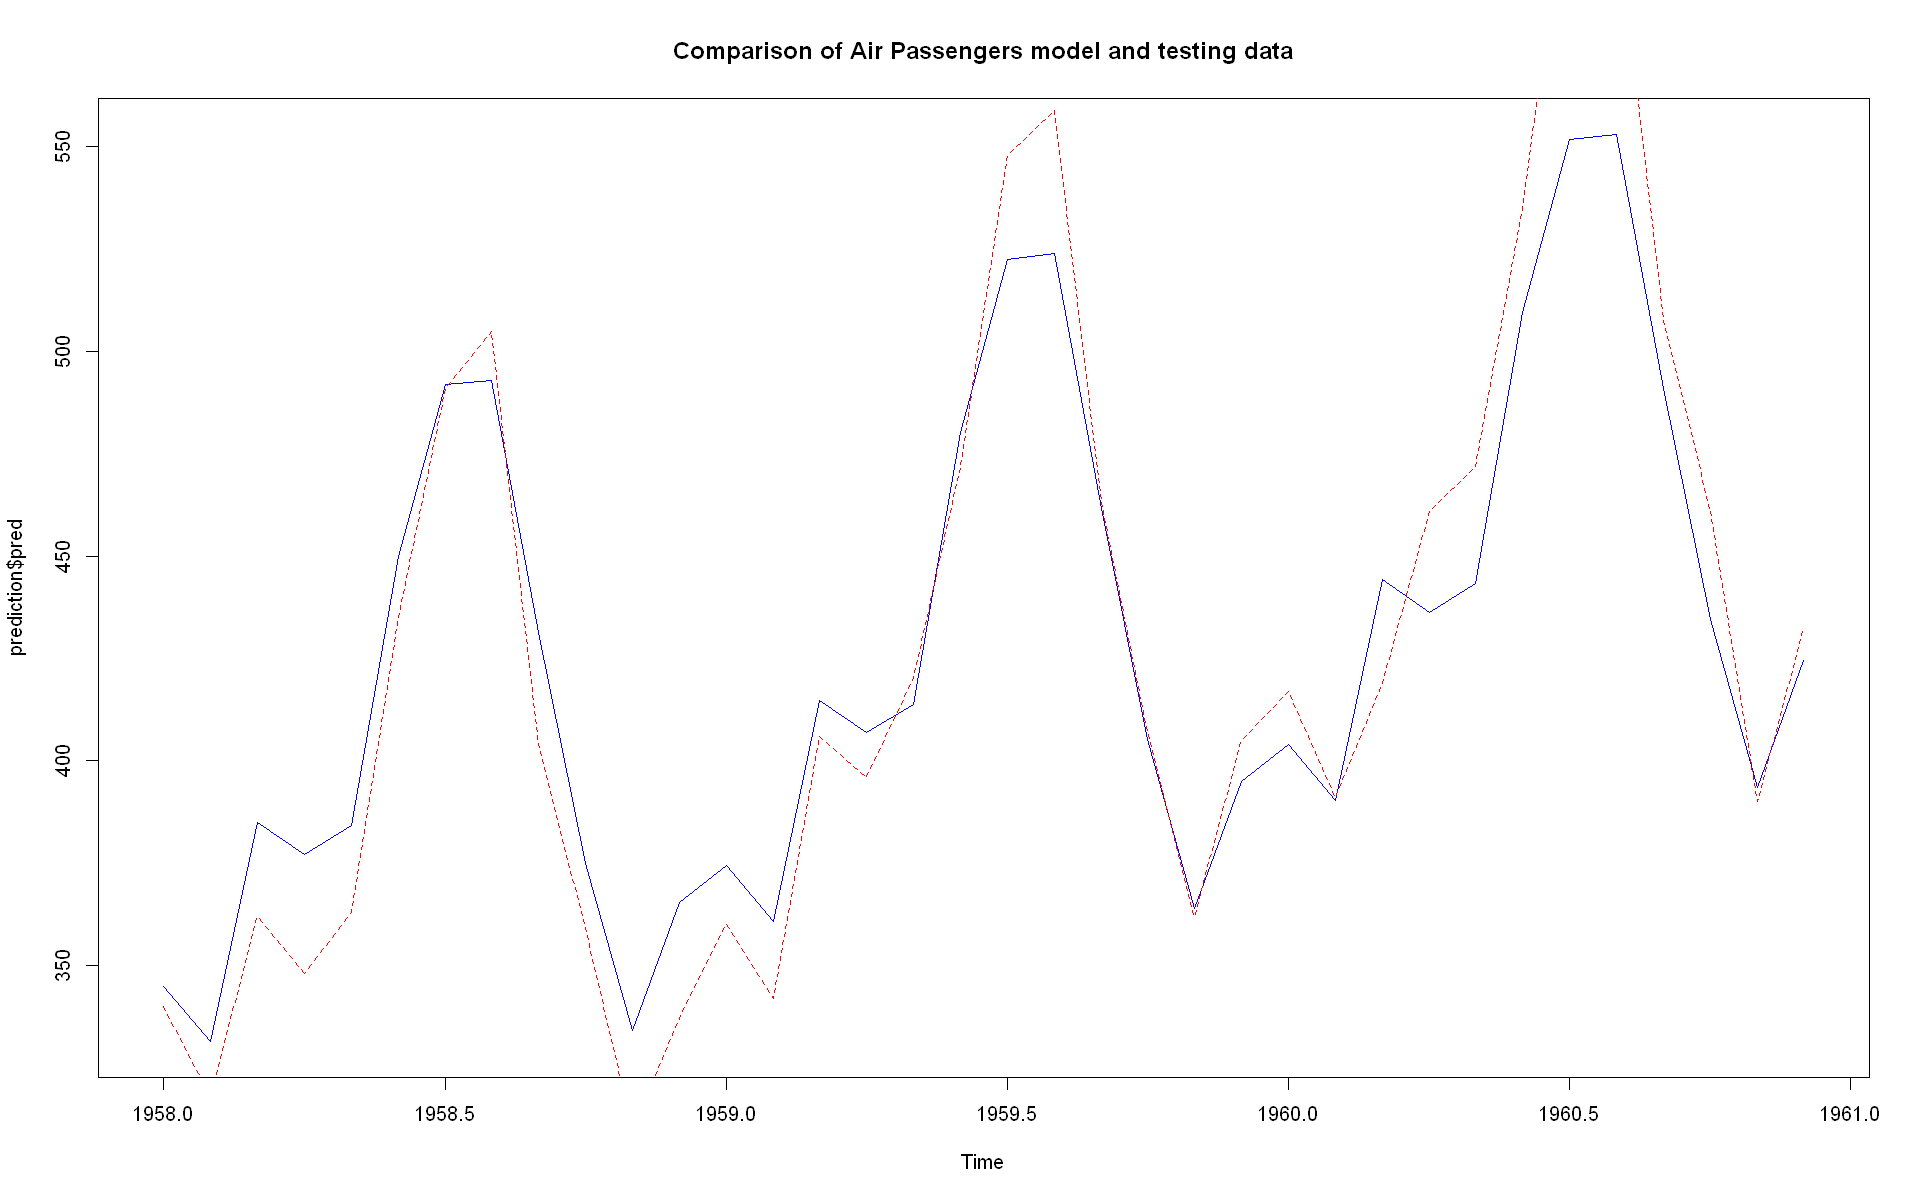

In [44]:
# Used for Jupyter notebook only
options(repr.plot.width=16, repr.plot.height=10)

# Show both side-by-side for comparison
opar <- par(no.readonly=TRUE)

plot(prediction$pred, 
     lty=1, 
     pch="o", 
     col = "Blue", 
     main = "Comparison of Air Passengers model and testing data")

# Plot second dataset
lines(testing, 
      col="red", 
      pch="*", 
      lty=2)

legend(1,19, legend=c("Prediction","Testing"), col=c("red","blue"),
                                   pch=c("o","*"),lty=c(1,2), ncol=1)

par(opar)
